# Konvolusi 1D untuk Pengolahan Sinyal Audio

Notebook ini membahas penerapan konvolusi 1 dimensi (1D Convolution) pada sinyal audio menggunakan JAX. Kita akan mempelajari bagaimana konvolusi dapat digunakan sebagai alat untuk mendeteksi pola nada tertentu dalam sebuah rekaman audio (seperti teknik *Matched Filtering*).

**Tujuan Pembelajaran:**
1. Memahami cara memuat dan memproses data audio dengan `librosa`.
2. Melakukan rekonstruksi nada secara manual berdasarkan frekuensi.
3. Menggunakan JAX `lax.conv_general_dilated` untuk melakukan konvolusi/korelasi 1D.
4. Memvisualisasikan hasil konvolusi untuk mendeteksi keberadaan nada.


### Langkah 1: Persiapan dan Impor Library

Kita mulai dengan menyiapkan lingkungan dan mengimpor library yang diperlukan. `librosa` digunakan untuk analisis audio, `jax` untuk operasi numerik yang efisien, dan `matplotlib` untuk visualisasi.

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import librosa #library for processing audio
from librosa.display import specshow # Import the spectroscope function...

# Loading interactive visualisation...
from plot_lib import set_default
import matplotlib.pyplot as plt
import numpy as np

# Import Jupyter utilities for playing audio
from IPython.display import display, Audio

import jax
import jax.numpy as jnp
from jax import lax

set_default(figsize=(16, 8))

### Langkah 2: Memuat Data Audio

Kita akan memuat file audio format `.wav`. Library `librosa.load` mengembalikan sinyal audio dalam bentuk array NumPy dan *sampling rate* (jumlah sampel per detik). Dalam contoh ini, kita menggunakan suara ikonik Windows XP Shutdown.

In [3]:
# Load audio
dataset = "../data/Windows20XP20Shutdown.wav"
x, sampling_rate = librosa.load(dataset)

print(f"{x.shape}: {x}")

(70641,): [ 4.1198730e-04 -6.1035156e-05  4.5776367e-05 ...  0.0000000e+00
 -1.5258789e-05  1.5258789e-05]


### Langkah 3: Visualisasi Sinyal Audio

Sebelum melakukan pemrosesan, kita visualisasikan sinyal audio dalam domain waktu untuk melihat bentuk gelombang (*waveform*). Kita juga menghitung durasi total dalam detik.

In [4]:
# Compute the temporal length of x(t)
T_duration = x.size / sampling_rate

print(
    f'x[k] has {x.size} samples',
    f'the sampling rate is {sampling_rate * 1e-3}kHz',
    f'x(t) is {T_duration:.1f}s long'
    , sep='\n')

x[k] has 70641 samples
the sampling rate is 22.05kHz
x(t) is 3.2s long


In [5]:
# Create x(t) time span
dt = 1 / sampling_rate
t = np.r_[0:T_duration:dt]
print(f'time span: {t.size} samples')

time span: 70641 samples


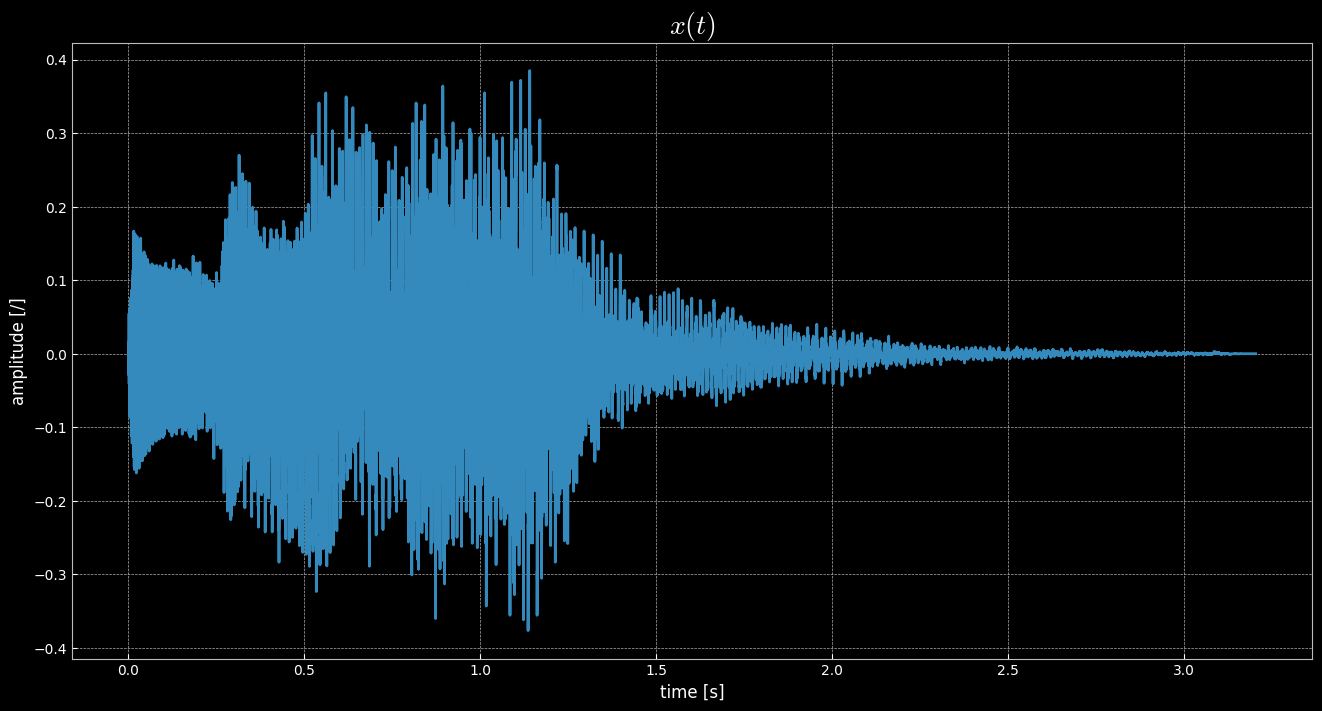

In [6]:
# Visualise x(t)
plt.figure()
plt.plot(t, x)
plt.xlabel('time [s]')
plt.ylabel('amplitude [/]')
plt.title(r'$x(t)$', size=20);

In [7]:
# Let's listen to x(t)
Audio(x, rate=sampling_rate)

In [8]:
# Compute Short-time Fourier transform (STFT) and convert the amplitude to dB
X_stft = librosa.stft(x)
X_dB = librosa.amplitude_to_db(np.abs(X_stft))

print(f"STFT shape: {X_stft.shape}, dB shape: {X_dB.shape}")

STFT shape: (1025, 138), dB shape: (1025, 138)


### Langkah 4: Rekonstruksi Melodi (Tuning Signals)

Misalkan kita ingin mencari nada-nada tertentu dalam audio tersebut. Di sini, kita mendefinisikan frekuensi untuk beberapa nada (Ab6, Eb6, Ab5, Bb5) dan menghasilkan sinyal sinus murni untuk masing-masing nada tersebut. Inilah yang akan menjadi 'kernel' atau filter kita dalam operasi konvolusi nanti.

In [ ]:
# ... and plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, x)
plt.xlim([0, T_duration])
plt.ylabel('amplitude [/]')
plt.title('Audio signal x(t) and its spectrogram X(t)')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.subplot(2,1,2)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.ylim(top=2000)
plt.grid(True)

In [9]:
# Manual recontruction of the melody:
Ab6 = 1661  # Hz
Eb6 = 1244  # Hz
Ab5 = 830   # Hz
Bb5 = 932   # Hz
TT = .4  # s
tt = np.r_[0:TT:dt]

# generate tones
A = {
    'a^(1)': np.sin(2 * np.pi * Ab6 * tt),
    'a^(2)': np.sin(2 * np.pi * Eb6 * tt),
    'a^(3)': np.sin(2 * np.pi * Ab5 * tt),
    'a^(4)': np.sin(2 * np.pi * Bb5 * tt),
}

# and concatenate them
xx = np.concatenate([a[1] for a in A.items()])

### Langkah 5: Operasi Konvolusi 1D dengan JAX

Sekarang kita masuk ke bagian inti. Kita menggunakan `jax.lax.conv_general_dilated` untuk mengonvolusi sinyal audio asli $x(t)$ dengan masing-masing nada 'rekaan' $a^{(i)}$.

Dalam konteks penyaringan sinyal, operasi ini sebenarnya lebih ke arah **korelasi**. JAX `conv_general_dilated` menerima input dengan format (N, C, L) yaitu *Batch*, *Channel*, dan *Length*. 

Hasil konvolusi yang tinggi (puncak) menunjukkan kecocokan yang kuat antara nada filter dengan bagian tertentu dalam audio asli.

a^(1) - input shape: (1, 1, 70641), weight shape: (1, 1, 8820), output shape: (1, 1, 70641)
a^(2) - input shape: (1, 1, 70641), weight shape: (1, 1, 8820), output shape: (1, 1, 70641)
a^(3) - input shape: (1, 1, 70641), weight shape: (1, 1, 8820), output shape: (1, 1, 70641)
a^(4) - input shape: (1, 1, 70641), weight shape: (1, 1, 8820), output shape: (1, 1, 70641)


Text(0.5, 0, 'time [s]')

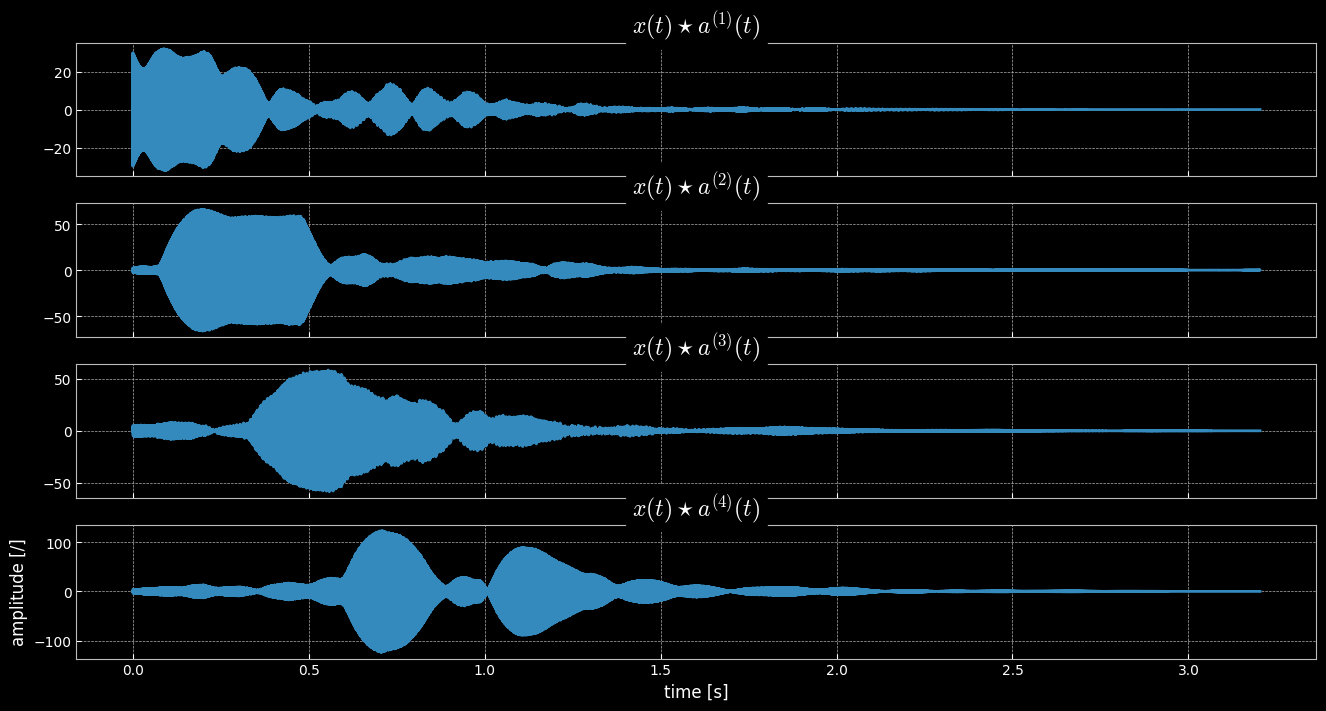

In [14]:
# Finally, let's convolve each tune a^(i) with x(t) using JAX
plt.figure()
convs = list()
n = 1
for name, signal in A.items():
    plt.subplot(4, 1, n)
    plt.title(rf'$x(t) \star a^{{({n})}}(t)$', backgroundcolor='black', verticalalignment='top', size=17)
    n += 1
    
    # Prepare inputs for conv_general_dilated (N, C, L)
    inp = jnp.array(x).reshape((1, 1, -1))
    # Weights for conv_general_dilated (O, I, L)
    # We reverse the kernel because lax.conv_general_dilated is a correlation
    # However, for symmetric/specific kernels it might not matter, but typically 
    # convolution = correlation with reversed kernel.
    weight = jnp.array(signal).reshape((1, 1, -1))
    
    # JAX convolution
    out = lax.conv_general_dilated(
        inp, 
        weight, 
        window_strides=(1,), 
        padding='SAME', 
        dimension_numbers=('NCL', 'OIL', 'NCL')
    )
    
    print(f"{name} - input shape: {inp.shape}, weight shape: {weight.shape}, output shape: {out.shape}")
    
    out_flat = out.flatten()
    convs.append(out_flat)
    plt.plot(t, out_flat)
    if n < 5: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)

plt.ylabel('amplitude [/]')
plt.xlabel('time [s]')

### Langkah 6: Hasil dan Verifikasi Suara

Terakhir, kita bisa mendengarkan kembali nada-nada yang telah direkonstruksi untuk memverifikasinya secara audio.

In [15]:
# Finally, let's listen to these convolutions!
for c in convs:
    display(Audio(np.array(c), rate=sampling_rate))